In [186]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import seaborn as sns

import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Display options
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

In [187]:
# -----------------------------
# Load your data
# -----------------------------
CSV_PATH = "../../data/claims_enhanced_rejections_export.csv"  # change if needed
df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)
df.head()

/var/folders/vn/_wr996295qz76c1mjm0c63h1fnbl15/T/ipykernel_40599/649523691.py:5: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


Loaded shape: (621489, 44)


,ClaimK9Number,procedure_code,claim_id,service_id,procedure_modifier_1,procedure_modifier_2,procedure_modifier_3,procedure_modifier_4,payer_identifier,service_charge_amount,service_unit_count,patient_gender,patient_birth_date_formatted,relation_to_insured,service_facility_state,service_facility_zip,rendering_provider_specialty_code,drug_ndc_code,billing_npi,rendering_provider_npi,service_start_date_formatted,place_of_service_code,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4,diagnosis_5,diagnosis_6,diagnosis_7,diagnosis_8,diagnosis_9,diagnosis_10,primary_cpt,secondary_cpt,procedure_3,procedure_4,procedure_5,procedure_6,procedure_7,procedure_8,procedure_9,procedure_10,CLEARINGHOUSETRACKINGNUMBER,denied
0,1484430Z122,J3490,2474932,7860084,JZ,NaN,NaN,NaN,WELM2,55.0,1.0,M,1944-09-10,18.0,TX,752548148,363LF0000X,6.332302e+10,1821573650,1.497203e+09,2023-01-04,11,G89.4,M79.605,M79.604,E11.40,NaN,NaN,NaN,NaN,NaN,NaN,J3490,99199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2301042880831,0
1,1490934Z122,64640,2207568,7891648,NaN,NaN,NaN,NaN,71064,2000.0,4.0,M,1948-09-05,18.0,OK,731421919,363LP2300X,NaN,1104437219,1.700493e+09,2023-01-18,11,G89.4,M79.671,M79.672,E11.40,R20.2,NaN,NaN,NaN,NaN,NaN,64640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2301191726411,0
2,1495056Z122,97110,2175144,7911593,GP,NaN,NaN,NaN,00923,70.0,1.0,F,1944-03-11,18.0,VA,235054629,363L00000X,NaN,1386187540,1.578106e+09,2023-01-30,11,R26.81,M62.81,R26.89,M62.831,M21.372,M79.671,M79.672,M25.571,M21.069,R20.2,97110,97112,97016,J1955,A4217,NaN,NaN,NaN,NaN,NaN,2301303320858,0
3,1495056Z122,97110,2123450,7911593,GP,NaN,NaN,NaN,00923,70.0,1.0,F,1944-03-11,18.0,VA,235054629,363L00000X,NaN,1386187540,1.578106e+09,2023-01-30,11,R26.81,M62.81,R26.89,M62.831,M21.372,M79.671,M79.672,M25.571,M21.069,R20.2,97110,97112,97016,J1955,NaN,NaN,NaN,NaN,NaN,NaN,2301303320858,0
4,1495056Z122,97110,2066305,7911593,GP,NaN,NaN,NaN,00923,70.0,1.0,F,1944-03-11,18.0,VA,235054629,363L00000X,NaN,1386187540,1.578106e+09,2023-01-30,11,R26.81,M62.81,R26.89,M62.831,M21.372,M79.671,M79.672,M25.571,M21.069,R20.2,97110,97112,97016,J1955,A4217,NaN,NaN,NaN,NaN,NaN,2301303320858,0


In [188]:
# -----------------------------
# Define base columns
# -----------------------------
numeric_cols = ["service_charge_amount", "service_unit_count"]

date_cols = [
    "patient_birth_date_formatted",
    "service_start_date_formatted",
    "service_end_date",
]

# Identify diagnosis and modifier columns dynamically
diagnosis_cols = [c for c in df.columns if c.startswith("diagnosis_")]
modifier_cols = [c for c in df.columns if c.startswith("procedure_modifier_")]

# Identify procedure columns:
# include optional 'cpt'/'secondary_cpt' if present, plus procedure_1..procedure_10
procedure_cols = []
for base in ["primary_cpt", "secondary_cpt"]:
    if base in df.columns:
        procedure_cols.append(base)
procedure_cols += [c for c in df.columns if re.fullmatch(r"procedure_\\d+", c)]

print("Found diagnosis_cols:", diagnosis_cols)
print("Found modifier_cols:", modifier_cols)
print("Found procedure_cols:", procedure_cols)

# Categorical columns to label-encode (besides procedures & diagnoses)
base_categoricals = [
    "payer_identifier",
    "patient_gender",
    "relation_to_insured",
    "service_facility_state",
    "rendering_provider_specialty_code",
    "place_of_service_code",
]
# Add modifiers, diagnoses, and procedures to categorical set
categorical_cols = base_categoricals + modifier_cols + diagnosis_cols + procedure_cols


Found diagnosis_cols: ['diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_4', 'diagnosis_5', 'diagnosis_6', 'diagnosis_7', 'diagnosis_8', 'diagnosis_9', 'diagnosis_10']
Found modifier_cols: ['procedure_modifier_1', 'procedure_modifier_2', 'procedure_modifier_3', 'procedure_modifier_4']
Found procedure_cols: ['primary_cpt', 'secondary_cpt']


In [189]:
# -----------------------------
# Date feature engineering
# -----------------------------
def engineer_date_features(frame: pd.DataFrame) -> pd.DataFrame:
    f = frame.copy()
    f["patient_birth_date_formatted"] = pd.to_datetime(
        f.get("patient_birth_date_formatted"), errors="coerce"
    )
    f["service_start_date_formatted"] = pd.to_datetime(
        f.get("service_start_date_formatted"), errors="coerce"
    )

    # Age at time of service (years, rounded)
    f["patient_age"] = (
        (f["service_start_date_formatted"] - f["patient_birth_date_formatted"])
        .dt.days.div(365.25)
        .round()
        .astype("Int64")
    )

    # Service duration (days); if end date missing, set to 0
    if "service_end_date" in f.columns:
        end_dates = pd.to_datetime(f["service_end_date"], errors="coerce")
        f["service_duration"] = (
            (end_dates - f["service_start_date_formatted"])
            .dt.days.fillna(0)
            .astype(int)
        )
    else:
        f["service_duration"] = 0

    # Month / weekday of service start
    f["service_month"] = f["service_start_date_formatted"].dt.month.astype("Int64")
    f["service_dayofweek"] = f["service_start_date_formatted"].dt.weekday.astype("Int64")
    return f

df = engineer_date_features(df)
df[["patient_age","service_duration","service_month","service_dayofweek"]].head()


,patient_age,service_duration,service_month,service_dayofweek
0,78,0,1,2
1,74,0,1,2
2,79,0,1,0
3,79,0,1,0
4,79,0,1,0


In [190]:
# -----------------------------
# Engineered features
# -----------------------------

# 1) icd_count
if len(diagnosis_cols) > 0:
    df["icd_count"] = df[diagnosis_cols].apply(
        lambda r: ((r.notna()) & (r.astype(str).str.strip() != "")).sum(), axis=1
    ).astype(int)
else:
    df["icd_count"] = 0

# 2) modifier_count
if len(modifier_cols) > 0:
    df["modifier_count"] = df[modifier_cols].apply(
        lambda r: ((r.notna()) & (r.astype(str).str.strip() != "")).sum(), axis=1
    ).astype(int)
else:
    df["modifier_count"] = 0

# 3) has_modifier_25
def has_mod_25(row):
    for c in modifier_cols:
        v = row.get(c)
        if pd.notna(v) and str(v).strip() == "25":
            return 1
    return 0
df["has_modifier_25"] = df.apply(has_mod_25, axis=1).astype(int)

# 4) procedures_count
if len(procedure_cols) > 0:
    df["procedures_count"] = df[procedure_cols].apply(
        lambda r: ((r.notna()) & (r.astype(str).str.strip() != "")).sum(), axis=1
    ).astype(int)
else:
    df["procedures_count"] = 0

# 5) unique_procedure_count
def unique_nonempty(values):
    cleaned = [str(v).strip() for v in values if pd.notna(v) and str(v).strip() != ""]
    return len(set(cleaned))

if len(procedure_cols) > 0:
    df["unique_procedure_count"] = df[procedure_cols].apply(unique_nonempty, axis=1).astype(int)
else:
    df["unique_procedure_count"] = 0

df[["icd_count","modifier_count","has_modifier_25","procedures_count","unique_procedure_count"]].head()


,icd_count,modifier_count,has_modifier_25,procedures_count,unique_procedure_count
0,4,1,0,2,2
1,5,0,0,1,1
2,10,1,0,2,2
3,10,1,0,2,2
4,10,1,0,2,2


In [217]:
# === Time-based split on service date (leak-proof) + train-only label encoding (with UNK) ===

import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# -------------------------------------------------------------------
# 0) Assumptions from earlier cells:
#    - df: your full dataframe (already engineered with date/count features)
#    - categorical_cols: list of categorical column names (payer, CPTs, ICDs, modifiers, NPIs, etc.)
#    - numeric_cols: e.g., ["service_charge_amount", "service_unit_count"]
#    - engineered_cols: e.g., ["patient_age","service_duration","service_month","service_dayofweek",
#                              "icd_count","modifier_count","has_modifier_25","procedures_count","unique_procedure_count"]
#    - ARTIFACTS_DIR exists (Path("artifacts"))
# -------------------------------------------------------------------

# --- Option A: explicit go-live cutoff ---
CUTOFF = pd.Timestamp("2025-07-01")

# --- Safety: ensure service date is datetime ---
df["service_start_date_formatted"] = pd.to_datetime(df["service_start_date_formatted"], errors="coerce")

df_sorted = df.sort_values("service_start_date_formatted").reset_index(drop=True)

# Train = 2023-01-01 up to (but not including) cutoff
train_df = df_sorted[
    (df_sorted["service_start_date_formatted"] >= pd.Timestamp("2023-01-01")) &
    (df_sorted["service_start_date_formatted"] < CUTOFF)
].copy()

# Validation = strictly after cutoff
val_df = df_sorted[df_sorted["service_start_date_formatted"] >= CUTOFF].copy()

print(f"[Time Split] Cutoff={CUTOFF.date()}")
print("Train window:", train_df["service_start_date_formatted"].min(), "→", train_df["service_start_date_formatted"].max())
print("Val window  :", val_df["service_start_date_formatted"].min(),   "→", val_df["service_start_date_formatted"].max())
print("Train shape:", train_df.shape, " Valid shape:", val_df.shape)

# --- Train-only Label Encoding with UNK handling ---
UNK_TOKEN = "__UNK__"

[Time Split] Cutoff=2025-07-01
Train window: 2023-01-01 00:00:00 → 2025-06-30 00:00:00
Val window  : 2025-07-01 00:00:00 → 2025-08-15 00:00:00
Train shape: (593785, 53)  Valid shape: (19735, 53)


In [218]:


def fit_le_train_only_and_transform(train_s: pd.Series, val_s: pd.Series, colname: str):
    """Fit LabelEncoder on TRAIN vocab (+ UNK), map unknowns in VAL to UNK, and transform both."""
    le = LabelEncoder()
    train_vocab = pd.Series(train_s.astype(str).unique(), dtype=str)
    vocab_with_unk = pd.Index(train_vocab.tolist() + [UNK_TOKEN]).unique()
    le.fit(vocab_with_unk)

    tr_enc = le.transform(train_s.astype(str))

    val_raw = val_s.astype(str).copy()
    known = set(le.classes_)
    unknown_mask = ~val_raw.isin(known)
    if unknown_mask.any():
        val_raw.loc[unknown_mask] = UNK_TOKEN
    va_enc = le.transform(val_raw)

    # persist encoder
    joblib.dump(le, ARTIFACTS_DIR / f"label_encoder_{colname}.pkl")
    return tr_enc, va_enc

encoders_info = []
for col in categorical_cols:
    if col in train_df.columns:
        tr_enc, va_enc = fit_le_train_only_and_transform(train_df[col], val_df[col], col)
        train_df[f"{col}_encoded"] = tr_enc
        val_df[f"{col}_encoded"]   = va_enc
        encoders_info.append((col, len(joblib.load(ARTIFACTS_DIR / f"label_encoder_{col}.pkl").classes_)))
        print(f"[LE] TRAIN-only fitted: {col}")

# --- Assemble final features (same order used at inference) ---
final_features = (
    numeric_cols
    + [f"{c}_encoded" for c in categorical_cols if f"{c}_encoded" in train_df.columns]
    + engineered_cols
)

# Guard against missing engineered/numeric columns
missing_train = [c for c in final_features if c not in train_df.columns]
missing_val   = [c for c in final_features if c not in val_df.columns]
if missing_train or missing_val:
    print("[WARN] Missing features:",
          {"train_missing": missing_train, "val_missing": missing_val})

X_train, y_train = train_df[final_features], train_df["denied"].astype(int)
X_val,   y_val   = val_df[final_features],   val_df["denied"].astype(int)

print("Final feature count:", len(final_features))
print("X_train / X_val shapes:", X_train.shape, X_val.shape)

# --- LightGBM datasets (tell it which are categorical) ---
cat_cols = [c for c in X_train.columns if c.endswith("_encoded")]
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols, free_raw_data=False)
dval   = lgb.Dataset(X_val,   label=y_val,   categorical_feature=cat_cols, free_raw_data=False, reference=dtrain)


print("Train shape:", train_df.shape, " Valid shape:", val_df.shape)

[LE] TRAIN-only fitted: payer_identifier
[LE] TRAIN-only fitted: patient_gender
[LE] TRAIN-only fitted: relation_to_insured
[LE] TRAIN-only fitted: service_facility_state
[LE] TRAIN-only fitted: rendering_provider_specialty_code
[LE] TRAIN-only fitted: place_of_service_code
[LE] TRAIN-only fitted: procedure_modifier_1
[LE] TRAIN-only fitted: procedure_modifier_2
[LE] TRAIN-only fitted: procedure_modifier_3
[LE] TRAIN-only fitted: procedure_modifier_4
[LE] TRAIN-only fitted: diagnosis_1
[LE] TRAIN-only fitted: diagnosis_2
[LE] TRAIN-only fitted: diagnosis_3
[LE] TRAIN-only fitted: diagnosis_4
[LE] TRAIN-only fitted: diagnosis_5
[LE] TRAIN-only fitted: diagnosis_6
[LE] TRAIN-only fitted: diagnosis_7
[LE] TRAIN-only fitted: diagnosis_8
[LE] TRAIN-only fitted: diagnosis_9
[LE] TRAIN-only fitted: diagnosis_10
[LE] TRAIN-only fitted: primary_cpt
[LE] TRAIN-only fitted: secondary_cpt
Final feature count: 33
X_train / X_val shapes: (593785, 33) (19735, 33)
Train shape: (593785, 75)  Valid shap

In [219]:
# -----------------------------
# Final feature list
# -----------------------------
engineered_cols = [
    "patient_age",
    "service_duration",
    "service_month",
    "service_dayofweek",
    "icd_count",
    "modifier_count",
    "has_modifier_25",
    "procedures_count",
    "unique_procedure_count",
]

final_features = (
    ["service_charge_amount", "service_unit_count"]
    + [f"{c}_encoded" for c in categorical_cols if f"{c}_encoded" in train_df.columns]
    + engineered_cols
)

print("Num features:", len(final_features))

X_train = train_df[final_features]
y_train = train_df["denied"].astype(int)

X_val = val_df[final_features]
y_val = val_df["denied"].astype(int)

X_train.shape, X_val.shape

Num features: 33


((593785, 33), (19735, 33))

Class balance train -> pos: 122371, neg: 471414, scale_pos_weight: 3.852
Training until validation scores don't improve for 200 rounds
[100]	train's auc: 0.928802	train's binary_logloss: 0.361039	valid's auc: 0.793912	valid's binary_logloss: 0.424869
[200]	train's auc: 0.943898	train's binary_logloss: 0.32334	valid's auc: 0.804359	valid's binary_logloss: 0.399013
[300]	train's auc: 0.950689	train's binary_logloss: 0.303825	valid's auc: 0.803465	valid's binary_logloss: 0.395111
Early stopping, best iteration is:
[182]	train's auc: 0.942132	train's binary_logloss: 0.328083	valid's auc: 0.805307	valid's binary_logloss: 0.399761
Best iteration: 182
Validation ROC-AUC: 0.8053
Validation PR-AUC : 0.6044
Best threshold (max F1): 0.3883
Confusion Matrix:
 [[13386  2570]
 [ 1371  2408]]

Classification Report:
               precision    recall  f1-score   support

           0      0.907     0.839     0.872     15956
           1      0.484     0.637     0.550      3779

    accuracy          

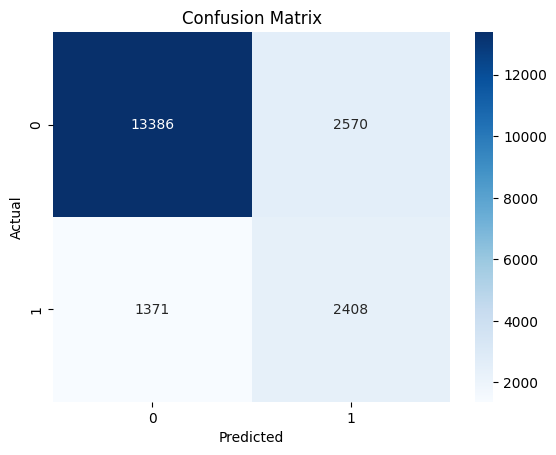

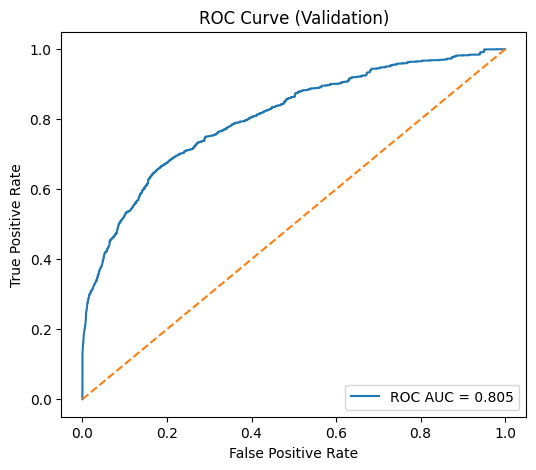

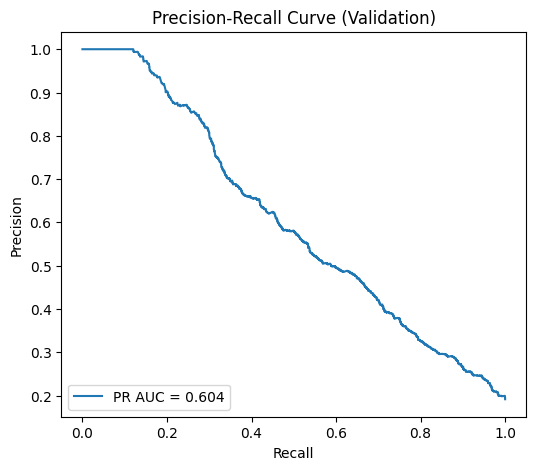

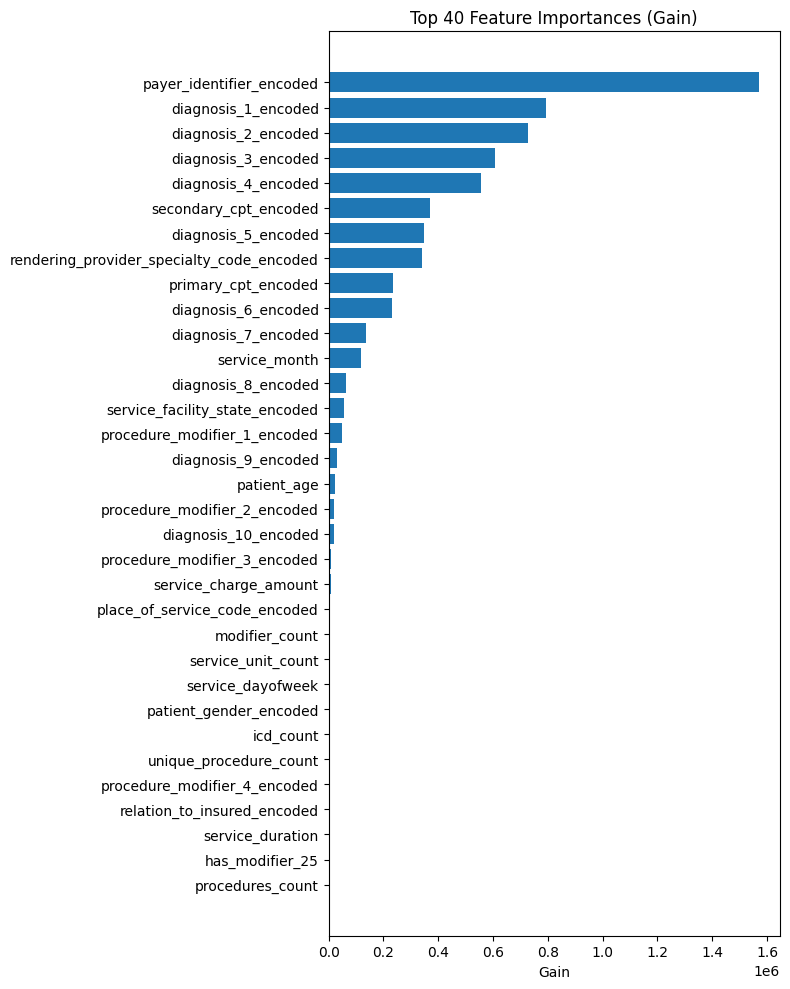

Saved sklearn LGBMClassifier to: /Users/rich.udicious/development/agentic-billing/score-denial-risk-model/model/jupyter/artifacts/lgbm_classifier.pkl
Saved LightGBM Booster to: /Users/rich.udicious/development/agentic-billing/score-denial-risk-model/model/jupyter/artifacts/lgbm_denial_model.txt
Saved misclassified validation rows to: /Users/rich.udicious/development/agentic-billing/score-denial-risk-model/model/jupyter/artifacts/val_misclassified.csv
Saved training meta to: /Users/rich.udicious/development/agentic-billing/score-denial-risk-model/model/jupyter/artifacts/training_meta.json


In [220]:
# -----------------------------
# LightGBM (sklearn) training & evaluation
# -----------------------------
import json
from pathlib import Path

import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, confusion_matrix, classification_report,
    roc_curve
)
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Identify categorical features (already encoded)
cat_cols = [c for c in X_train.columns if c.endswith("_encoded")]

# Handle class imbalance
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / max(pos, 1)) if pos > 0 else 1.0
print(f"Class balance train -> pos: {pos}, neg: {neg}, scale_pos_weight: {scale_pos_weight:.3f}")

# Make sure we have an artifacts dir
try:
    ARTIFACTS_DIR
except NameError:
    ARTIFACTS_DIR = Path("./artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Define classifier
clf = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    min_child_samples=50,          # (min_data_in_leaf)
    colsample_bytree=0.9,          # (feature_fraction)
    subsample=0.9,                 # (bagging_fraction)
    subsample_freq=1,              # (bagging_freq)
    scale_pos_weight=scale_pos_weight,
    n_estimators=5000,             # (num_boost_round)
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

# Train with early stopping (uses validation set)
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=["train", "valid"],
    eval_metric=["auc", "binary_logloss"],
    categorical_feature=cat_cols,  # column names are supported
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=100)
    ]
)

best_iter = getattr(clf, "best_iteration_", None)
print(f"Best iteration: {best_iter}")

# Predictions (positive-class probability)
val_proba = clf.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, val_proba)
pr_auc  = average_precision_score(y_val, val_proba)
print(f"Validation ROC-AUC: {roc_auc:.4f}")
print(f"Validation PR-AUC : {pr_auc:.4f}")

# Threshold tuning (maximize F1)
prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1 = 2 * (prec * rec) / np.maximum(prec + rec, 1e-12)
best_idx = np.nanargmax(f1) if len(f1) > 0 else 0
best_threshold = 0.5 if (len(thr) == 0 or best_idx >= len(thr)) else float(thr[best_idx])
print(f"Best threshold (max F1): {best_threshold:.4f}")
val_pred = (val_proba >= best_threshold).astype(int)

# Confusion matrix & report
cm = confusion_matrix(y_val, val_pred, labels=[0, 1])
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_val, val_pred, digits=3))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_val, val_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend(loc="lower right")
plt.show()

# PR curve
plt.figure(figsize=(6, 5))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend(loc="lower left")
plt.show()

# Feature importance from the underlying Booster
booster = clf.booster_
imp_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance_gain": booster.feature_importance(importance_type="gain"),
    "importance_split": booster.feature_importance(importance_type="split"),
}).sort_values("importance_gain", ascending=False)

topn = 40
plt.figure(figsize=(8, max(6, int(topn * 0.25))))
plt.barh(imp_df.head(topn)["feature"][::-1], imp_df.head(topn)["importance_gain"][::-1])
plt.xlabel("Gain")
plt.title(f"Top {topn} Feature Importances (Gain)")
plt.tight_layout()
plt.show()

# Save model & outputs (both sklearn model and booster text file)
model_pkl_path = ARTIFACTS_DIR / "lgbm_classifier.pkl"
joblib.dump(clf, model_pkl_path)
print(f"Saved sklearn LGBMClassifier to: {model_pkl_path.resolve()}")

model_txt_path = ARTIFACTS_DIR / "lgbm_denial_model.txt"
booster.save_model(str(model_txt_path), num_iteration=best_iter)
print(f"Saved LightGBM Booster to: {model_txt_path.resolve()}")

# Save misclassified rows
val_out = val_df.copy()
val_out["pred_proba"] = val_proba
val_out["pred_label"] = val_pred
val_out["threshold_used"] = best_threshold
misclassified = val_out[val_out["pred_label"] != val_out["denied"]]
mis_path = ARTIFACTS_DIR / "val_misclassified.csv"
misclassified.to_csv(mis_path, index=False)
print(f"Saved misclassified validation rows to: {mis_path.resolve()}")

# Save training metadata
meta = {
    "best_iteration": int(best_iter) if best_iter is not None else None,
    "params": clf.get_params(deep=False),
    "threshold": float(best_threshold),
    "roc_auc": float(roc_auc),
    "pr_auc": float(pr_auc),
    "categorical_features": cat_cols,
    "final_features": list(X_train.columns),
}
with open(ARTIFACTS_DIR / "training_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print(f"Saved training meta to: {(ARTIFACTS_DIR / 'training_meta.json').resolve()}")


Loaded LGBMClassifier from artifacts/lgbm_classifier.pkl
Loaded training meta from artifacts/training_meta.json
Expecting 22 raw categorical columns for encoding (from meta).
Loaded raw dataset: ../../data/claims_enhanced_rejections_export.csv shape=(621489, 44)


/var/folders/vn/_wr996295qz76c1mjm0c63h1fnbl15/T/ipykernel_40599/1508029424.py:57: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return len(pd.unique(vals))


Data set columns: Index(['ClaimK9Number', 'procedure_code', 'claim_id', 'service_id', 'procedure_modifier_1', 'procedure_modifier_2', 'procedure_modifier_3',
       'procedure_modifier_4', 'payer_identifier', 'service_charge_amount', 'service_unit_count', 'patient_gender', 'patient_birth_date_formatted',
       'relation_to_insured', 'service_facility_state', 'service_facility_zip', 'rendering_provider_specialty_code', 'drug_ndc_code', 'billing_npi',
       'rendering_provider_npi', 'service_start_date_formatted', 'place_of_service_code', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_4',
       'diagnosis_5', 'diagnosis_6', 'diagnosis_7', 'diagnosis_8', 'diagnosis_9', 'diagnosis_10', 'primary_cpt', 'secondary_cpt', 'procedure_3', 'procedure_4',
       'procedure_5', 'procedure_6', 'procedure_7', 'procedure_8', 'procedure_9', 'procedure_10', 'CLEARINGHOUSETRACKINGNUMBER', 'denied', 'patient_age',
       'service_duration', 'service_month', 'service_dayofweek', 'icd_count', 'mo

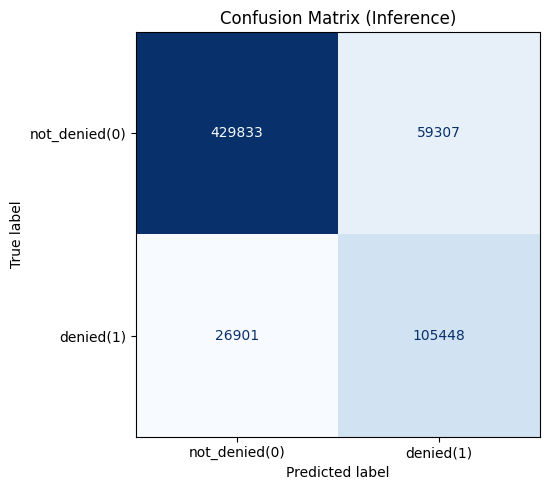

Saved predictions to: /Users/rich.udicious/development/agentic-billing/score-denial-risk-model/model/jupyter/predictions_inference.csv


In [224]:
# === End-to-end: transform raw claims CSV -> X_ready -> predict_proba (LGBMClassifier only) ===
# Fixed: strip_decimal_suffix now uses a capturing group instead of a lookbehind.

import re
import json
from pathlib import Path

import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# -------------------
# Config
# -------------------
RAW_PATH      = Path("../../data/claims_enhanced_rejections_export.csv")  # your sample path
ARTIFACTS_DIR = Path("./artifacts")
MODEL_PATH    = ARTIFACTS_DIR / "lgbm_classifier.pkl"
META_PATH     = ARTIFACTS_DIR / "training_meta.json"
TARGET_COL    = "denied"
OUT_CSV       = Path("./predictions_inference.csv")

# -------------------
# Helpers
# -------------------
def to_str_series(s: pd.Series) -> pd.Series:
    return s.astype(str)

def strip_decimal_suffix(s: pd.Series) -> pd.Series:
    """
    Turn tokens like '1497202915.0' -> '1497202915' (but keep '1.01' as-is).
    Uses a capturing group (no variable-width lookbehind).
    """
    return s.str.replace(r'^(\d+)\.0$', r'\1', regex=True)

def clean_token_series(s: pd.Series) -> pd.Series:
    s = to_str_series(s).str.strip()
    s = strip_decimal_suffix(s)
    return s.replace({"nan": np.nan, "None": np.nan, "": np.nan})

def count_nonempty(df: pd.DataFrame, cols: list) -> pd.Series:
    if not cols:
        return pd.Series(0, index=df.index)
    m = df[cols].apply(lambda x: x.notna() & (x.astype(str).str.len() > 0), axis=0)
    return m.sum(axis=1)

def nunique_nonempty(df: pd.DataFrame, cols: list) -> pd.Series:
    if not cols:
        return pd.Series(0, index=df.index)
    def _row_nuniq(row):
        vals = [v for v in row if pd.notna(v) and str(v) != ""]
        return len(pd.unique(vals))
    return df[cols].apply(_row_nuniq, axis=1)

def ensure_columns_present(df: pd.DataFrame, cols: list, ctx: str):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise RuntimeError(
            f"Missing {len(missing)} required column(s) for {ctx}: {missing[:20]}{' ...' if len(missing) > 20 else ''}"
        )

def load_encoder_mapping(col: str, artifacts_dir: Path):
    path = artifacts_dir / f"label_encoder_{col}.pkl"
    if not path.exists():
        raise RuntimeError(f"Missing encoder file: {path.name} (for raw column '{col}')")
    le = joblib.load(path)
    classes = getattr(le, "classes_", None)
    if classes is None:
        raise RuntimeError(f"Encoder {path.name} has no classes_. Recreate encoders from training.")
    return {cls: i for i, cls in enumerate(classes)}  # unseen -> NaN via map

# -------------------
# Load model + meta
# -------------------
if not MODEL_PATH.exists():
    raise RuntimeError(f"Model not found: {MODEL_PATH}")
model = joblib.load(MODEL_PATH)
print(f"Loaded LGBMClassifier from {MODEL_PATH}")

if not META_PATH.exists():
    raise RuntimeError(f"training_meta.json not found: {META_PATH}")
with open(META_PATH, "r") as f:
    meta = json.load(f)
print(f"Loaded training meta from {META_PATH}")

final_features = meta.get("final_features")
cat_encoded    = meta.get("categorical_features")  # names like *_encoded
if not isinstance(final_features, list) or not final_features:
    raise RuntimeError("'final_features' missing or invalid in training_meta.json.")
if not isinstance(cat_encoded, list) or not cat_encoded:
    raise RuntimeError("'categorical_features' missing or invalid in training_meta.json.")

# Derive raw categorical column names from *_encoded list
raw_cat_cols = []
for c in cat_encoded:
    raw_cat_cols.append(c[:-8] if c.endswith("_encoded") else c)
raw_cat_cols = sorted(set(raw_cat_cols))
print(f"Expecting {len(raw_cat_cols)} raw categorical columns for encoding (from meta).")

# -------------------
# Load raw data
# -------------------
if not RAW_PATH.exists():
    raise RuntimeError(f"Raw dataset not found at {RAW_PATH}")
df = pd.read_csv(RAW_PATH, low_memory=False)
print(f"Loaded raw dataset: {RAW_PATH} shape={df.shape}")

# -------------------
# Define dynamic groups to mirror training
# -------------------
numeric_cols = ["service_charge_amount", "service_unit_count"]

date_cols = ["patient_birth_date_formatted", "service_start_date_formatted"]
if "service_end_date" in df.columns:
    date_cols += ["service_end_date"]

diagnosis_cols = [c for c in df.columns if c.startswith("diagnosis_")]
modifier_cols  = [c for c in df.columns if c.startswith("procedure_modifier_")]

procedure_cols = []
for base in ["primary_cpt", "secondary_cpt"]:
    if base in df.columns:
        procedure_cols.append(base)
procedure_cols += [c for c in df.columns if re.fullmatch(r"procedure_\d+", c)]

# -------------------
# Coerce numerics and parse dates
# -------------------
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce") if c in df.columns else pd.NaT

# -------------------
# Clean token-like IDs so they match encoders
# -------------------
id_like_cols = set([
    "payer_identifier",
    "patient_gender",
    "relation_to_insured",
    "service_facility_state",
    "service_facility_zip",
    "rendering_provider_specialty_code",
    "drug_ndc_code",
    "billing_npi",
    "rendering_provider_npi",
    "place_of_service_code",
    "primary_cpt",
    "secondary_cpt",
]) | set(diagnosis_cols) | set(modifier_cols) | set(procedure_cols)

for c in id_like_cols:
    if c in df.columns:
        df[c] = clean_token_series(df[c])

# -------------------
# Derived features (must match training)
# -------------------
if {"patient_birth_date_formatted", "service_start_date_formatted"}.issubset(df.columns):
    age_days = (df["service_start_date_formatted"] - df["patient_birth_date_formatted"]).dt.days
    df["patient_age"] = (age_days / 365.25).astype("float64")
else:
    df["patient_age"] = np.nan

if "service_start_date_formatted" in df.columns:
    if "service_end_date" in df.columns:
        dur = (df["service_end_date"] - df["service_start_date_formatted"]).dt.days
        df["service_duration"] = dur.clip(lower=0).fillna(0).astype("float64")
    else:
        df["service_duration"] = 0.0
    df["service_month"] = df["service_start_date_formatted"].dt.month.astype("Int64")
    df["service_dayofweek"] = df["service_start_date_formatted"].dt.dayofweek.astype("Int64")
else:
    df["service_duration"] = 0.0
    df["service_month"] = pd.Series([pd.NA] * len(df), dtype="Int64")
    df["service_dayofweek"] = pd.Series([pd.NA] * len(df), dtype="Int64")

df["icd_count"] = count_nonempty(df, diagnosis_cols).astype("int64")
df["modifier_count"] = count_nonempty(df, modifier_cols).astype("int64")
df["has_modifier_25"] = (
    (df[modifier_cols].apply(lambda s: s.astype(str).str.strip(), axis=0) == "25").any(axis=1)
    if modifier_cols else pd.Series(False, index=df.index)
).astype("int64")
df["procedures_count"] = count_nonempty(df, procedure_cols).astype("int64")
df["unique_procedure_count"] = nunique_nonempty(df, procedure_cols).astype("int64")

print(f"Data set columns: {df.columns}")
print(f"Raw columns: {raw_cat_cols}")

# -------------------
# Ensure required raw categoricals exist, then apply per-column LabelEncoders -> *_encoded
# -------------------
ensure_columns_present(df, raw_cat_cols, "raw categorical encoding")

for raw_col in raw_cat_cols:
    mapping = load_encoder_mapping(raw_col, ARTIFACTS_DIR)
    enc_name = f"{raw_col}_encoded"
    df[enc_name] = df[raw_col].map(mapping)  # unseen -> NaN (LightGBM handles)

print("Applied all per-column LabelEncoders and created *_encoded columns.")

# -------------------
# Build X_ready in exact final_features order
# -------------------
missing_final = [c for c in final_features if c not in df.columns]
if missing_final:
    raise RuntimeError(
        f"Inference data is missing {len(missing_final)} expected feature(s): "
        f"{missing_final[:25]}{' ...' if len(missing_final) > 25 else ''}"
    )
X_ready = df.reindex(columns=final_features)
print(f"X_ready shape: {X_ready.shape}")

# -------------------
# Inference
# -------------------
if not hasattr(model, "predict_proba"):
    raise RuntimeError("Loaded model has no predict_proba. Ensure you saved an LGBMClassifier or calibrated wrapper.")
proba = model.predict_proba(X_ready)
if proba.ndim != 2 or proba.shape[1] < 2:
    raise RuntimeError("predict_proba did not return a binary-probability matrix.")
y_scores = proba[:, 1].ravel()
print(f"Example probabilities: {np.round(y_scores[:5], 4)}")

# Optional evaluation if target available in raw
y_eval = df[TARGET_COL].astype(int).values.ravel() if TARGET_COL in df.columns else None
best_threshold = meta.get("threshold")

if y_eval is not None:
    roc_auc = roc_auc_score(y_eval, y_scores)
    pr_auc  = average_precision_score(y_eval, y_scores)
    print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")

    if best_threshold is None:
        prec, rec, thr = precision_recall_curve(y_eval, y_scores)
        if len(thr) > 0:
            f1 = 2 * (prec[:-1] * rec[:-1]) / np.maximum(prec[:-1] + rec[:-1], 1e-12)
            best_threshold = float(thr[int(np.nanargmax(f1))])
            print(f"Chosen threshold (max F1 on current data): {best_threshold:.4f}")
        else:
            best_threshold = float(np.median(y_scores))
            print(f"Chosen threshold (median fallback): {best_threshold:.4f}")
    else:
        print(f"Using saved threshold from training_meta.json: {best_threshold:.4f}")

    y_pred = (y_scores >= best_threshold).astype(int)
    cm = confusion_matrix(y_eval, y_pred, labels=[0, 1])
    print("Confusion Matrix [labels 0,1]:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_eval, y_pred, labels=[0,1], target_names=["not_denied(0)", "denied(1)"], digits=4))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_denied(0)", "denied(1)"])
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
    ax.set_title("Confusion Matrix (Inference)")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.tight_layout()
    plt.show()
else:
    if best_threshold is None:
        best_threshold = 0.5
        print("No labels and no saved threshold found. Using default threshold=0.5.")
    y_pred = (y_scores >= best_threshold).astype(int)

# -------------------
# Save predictions
# -------------------
out_df = df.copy()
out_df["pred_proba"] = y_scores
out_df["pred_label"] = y_pred
out_df["threshold_used"] = best_threshold
out_df.to_csv(OUT_CSV, index=False)
print(f"Saved predictions to: {OUT_CSV.resolve()}")
